# Random Forest Models

import statements:

In [15]:
from numpy import ndarray
from pandas import DataFrame, read_csv, unique
from matplotlib.pyplot import figure, subplots, savefig, show
from sklearn.ensemble import RandomForestClassifier
from ds_charts import plot_evaluation_results, multiple_line_chart, horizontal_bar_chart, HEIGHT
from numpy import std, argsort

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

file_tag = 'NYC_collisions'
target = 'PERSON_INJURY'

In [13]:
def plot_overfitting_study(xvalues, prd_trn, prd_tst, name, xlabel, ylabel):
    evals = {'Train': prd_trn, 'Test': prd_tst}
    plt.figure()
    multiple_line_chart(xvalues, evals, ax = None, title=f'Overfitting {name}', xlabel=xlabel, ylabel=ylabel, percentage=True)
    plt.savefig('images/overfitting_{name}.png')

## Dummified data with scaling

load dataframes:

In [3]:
train: DataFrame = read_csv('data/train_sets/with_scaling.csv')
trnY: ndarray = train.pop(target).values
trnX: ndarray = train.values
labels = unique(trnY)
labels.sort()

test: DataFrame = read_csv('data/test_sets/with_scaling.csv')
tstY: ndarray = test.pop(target).values
tstX: ndarray = test.values

train models:

<Figure size 600x450 with 0 Axes>

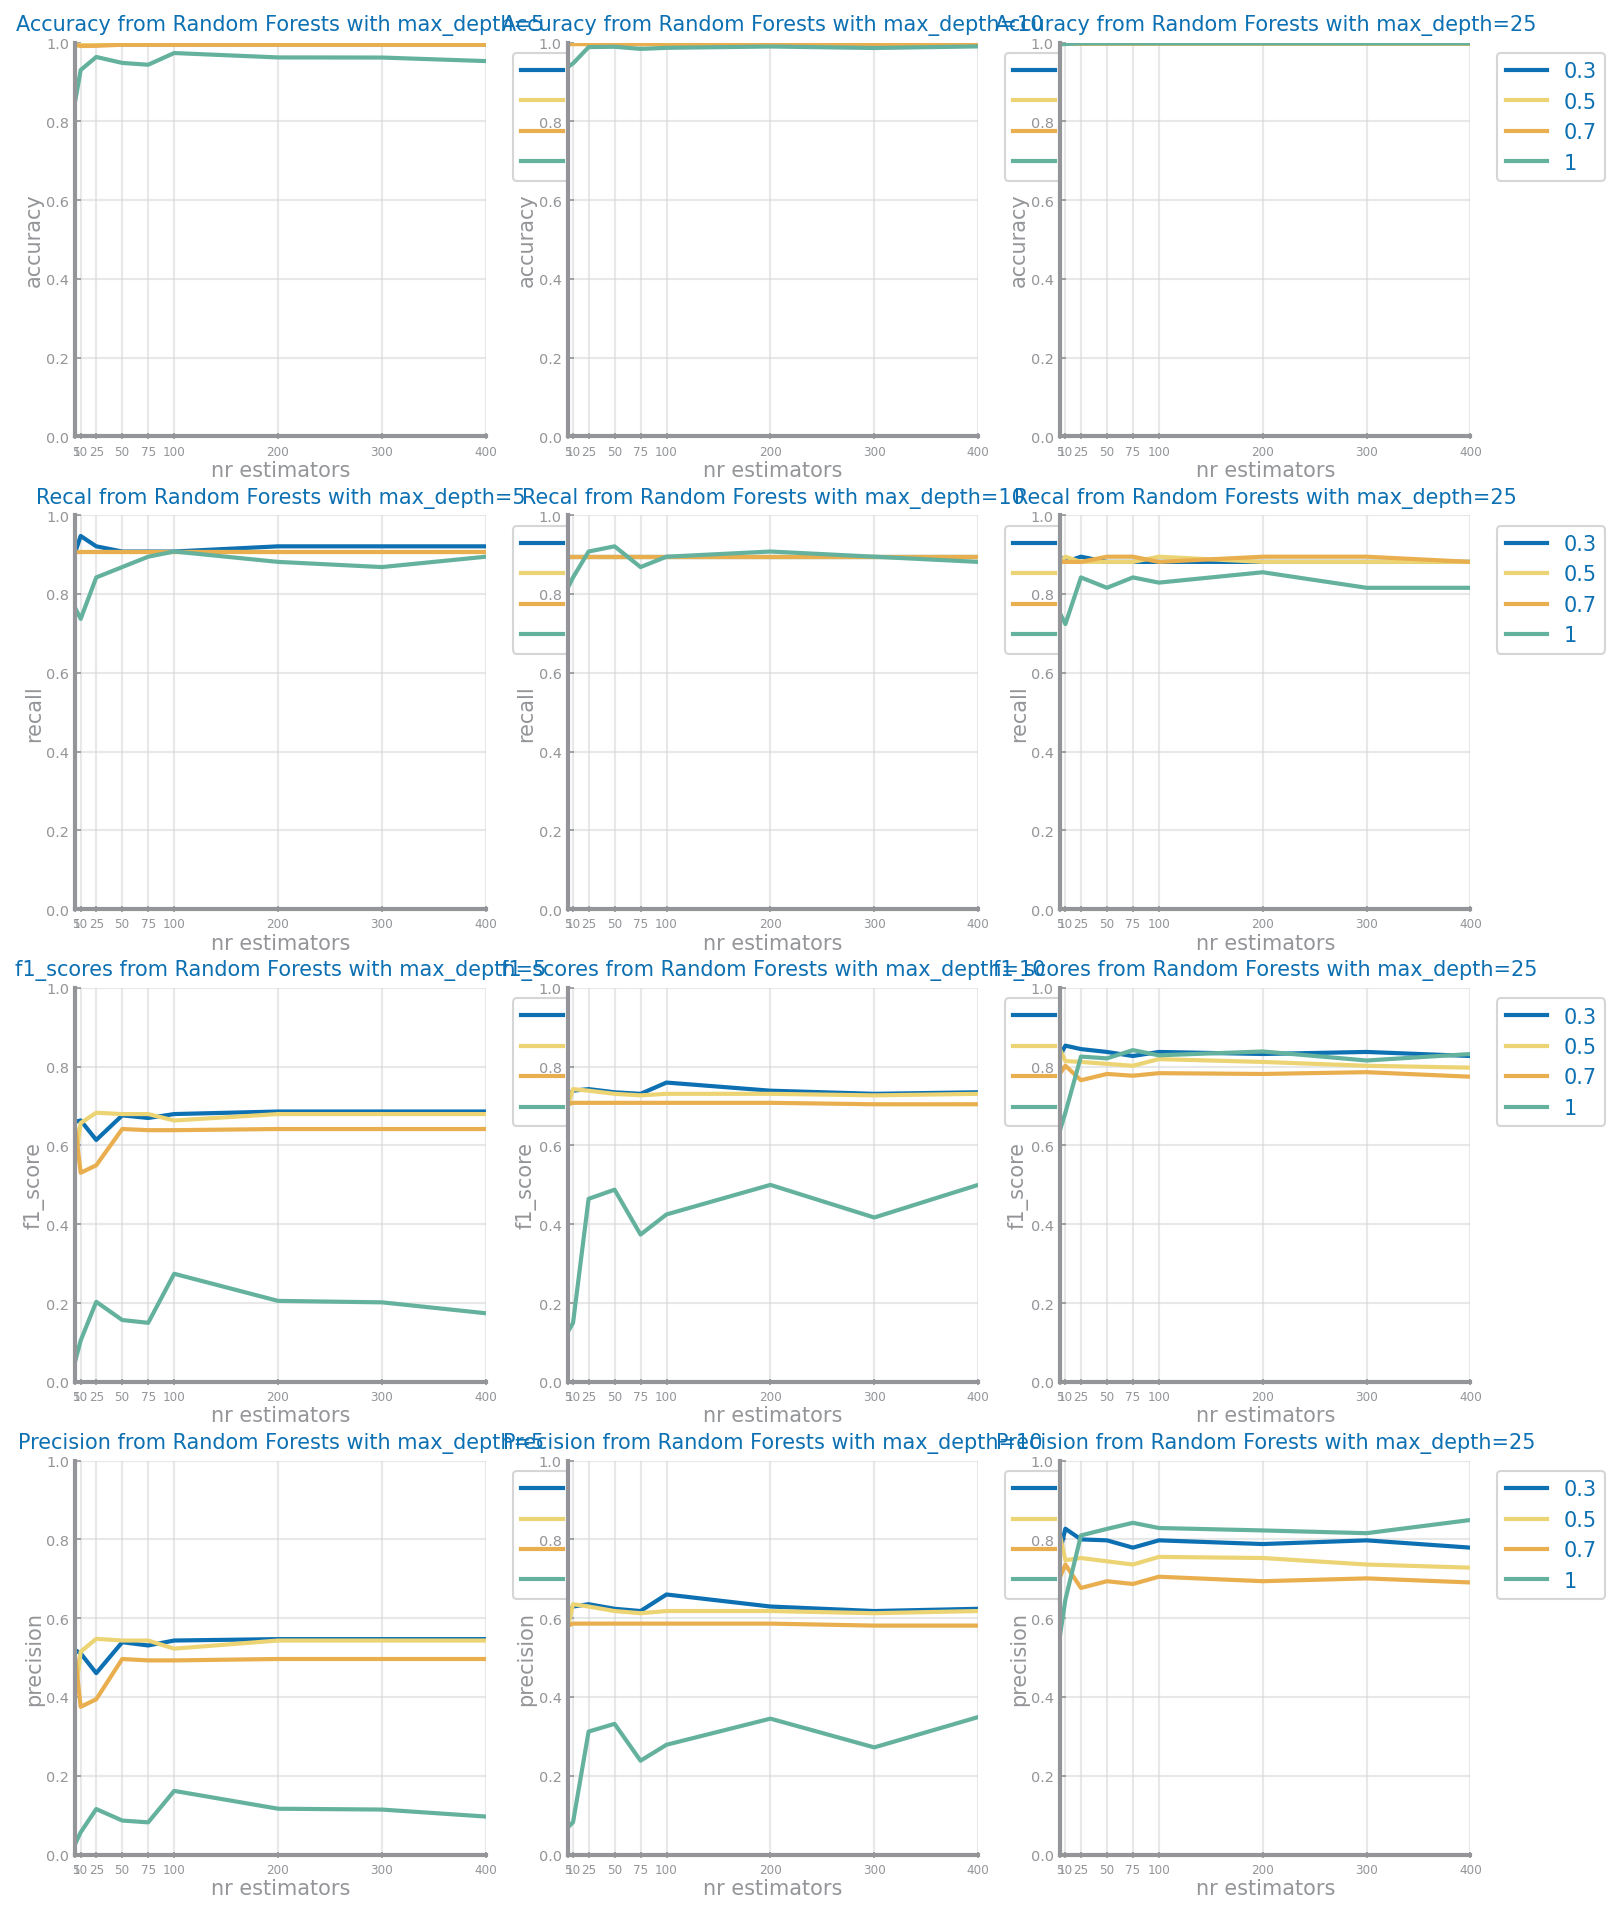

Best results with depth=25, 0.30 features and 10 estimators, with accuracy=1.00


In [8]:
n_estimators = [5, 10, 25, 50, 75, 100, 200, 300, 400]
max_depths = [5, 10, 25]
max_features = [.3, .5, .7, 1]
best = ('', 0, 0)
last_best = 0
best_model = None


cols = len(max_depths)
figure()
fig, axs = subplots(4, cols, figsize=(cols*HEIGHT, 4*HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]

    acc_values = {}
    recall_values = {}
    f1_values = {}
    precision_values = {}

    for f in max_features:
        recall = []
        f1_score = []
        accuracy = []
        precision = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)

            accuracy.append(metrics.accuracy_score(tstY, prdY))
            recall.append(metrics.recall_score(tstY, prdY, pos_label='Killed'))
            f1_score.append(metrics.f1_score(tstY, prdY, pos_label="Killed"))
            precision.append(metrics.precision_score(tstY, prdY, pos_label="Killed"))

            if accuracy[-1] > last_best:
                best = (d, f, n)
                last_best = accuracy[-1]
                best_model = rf
                
        precision_values[f] = precision
        acc_values[f] = accuracy
        recall_values[f] = recall
        f1_values[f] = f1_score

    multiple_line_chart(n_estimators, acc_values, ax=axs[0, k], title=f'Accuracy from Random Forests with max_depth={d}',
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
    multiple_line_chart(n_estimators, recall_values, ax=axs[1, k], title=f'Recal from Random Forests with max_depth={d}',
                           xlabel='nr estimators', ylabel='recall', percentage=True)
    multiple_line_chart(n_estimators, f1_values, ax=axs[2, k], title=f'f1_scores from Random Forests with max_depth={d}',
                           xlabel='nr estimators', ylabel='f1_score', percentage=True)
    multiple_line_chart(n_estimators, precision_values, ax=axs[3, k], title=f'Precision from Random Forests with max_depth={d}',
                           xlabel='nr estimators', ylabel='precision', percentage=True)

savefig(f'images/{file_tag}_scl_rf_study.png')
show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

after analysis, define the best model:

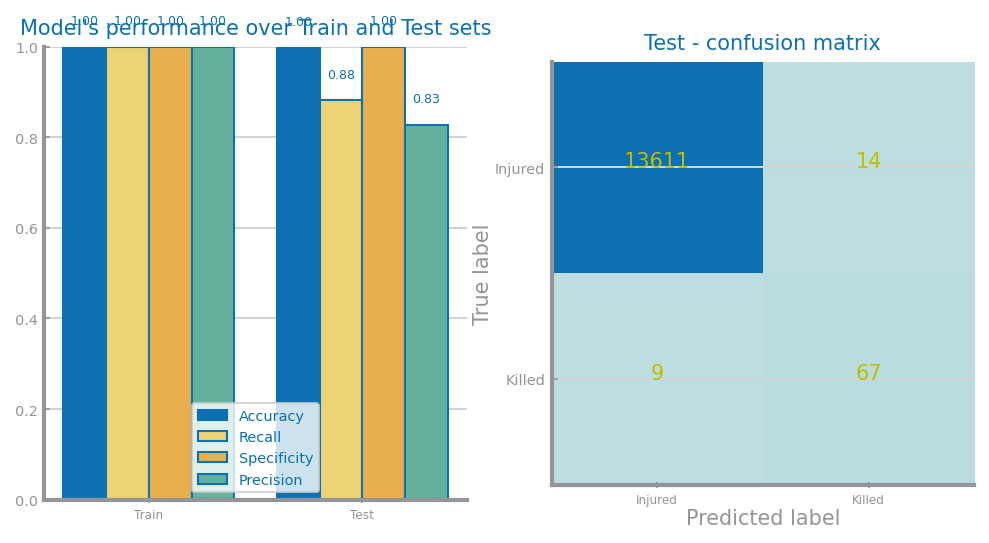

In [9]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
savefig(f'images/{file_tag}_scl_rf_best.png')
show()

1. feature EMOTIONAL_STATUS_Conscious (0.47194644630959387)
2. feature EMOTIONAL_STATUS_Apparent Death (0.21058431683264328)
3. feature COMPLAINT_Complaint of Pain or Nausea (0.09503942877549298)
4. feature EMOTIONAL_STATUS_Unconscious (0.06122165556390621)
5. feature BODILY_INJURY_Head (0.041946367219205825)
6. feature COMPLAINT_Internal (0.03557032613677967)
7. feature EMOTIONAL_STATUS_Unknown (0.014750717522932756)
8. feature BODILY_INJURY_Entire Body (0.014422750933124461)
9. feature EMOTIONAL_STATUS_Shock (0.009335208348120051)
10. feature EJECTION_Not Ejected (0.00910111021779563)
11. feature EMOTIONAL_STATUS_Semiconscious (0.0038546311672903693)
12. feature COMPLAINT_Minor Bleeding (0.0029145184044897555)
13. feature PERSON_AGE (0.002835203692386324)
14. feature PERSON_SEX_F (0.00270869887839428)
15. feature CRASH_TIME (0.0026842465523813745)
16. feature BODILY_INJURY_Neck (0.0024212942163086837)
17. feature PERSON_TYPE_Other Motorized (0.0016827624797720888)
18. feature EMOTION

<Figure size 600x450 with 0 Axes>

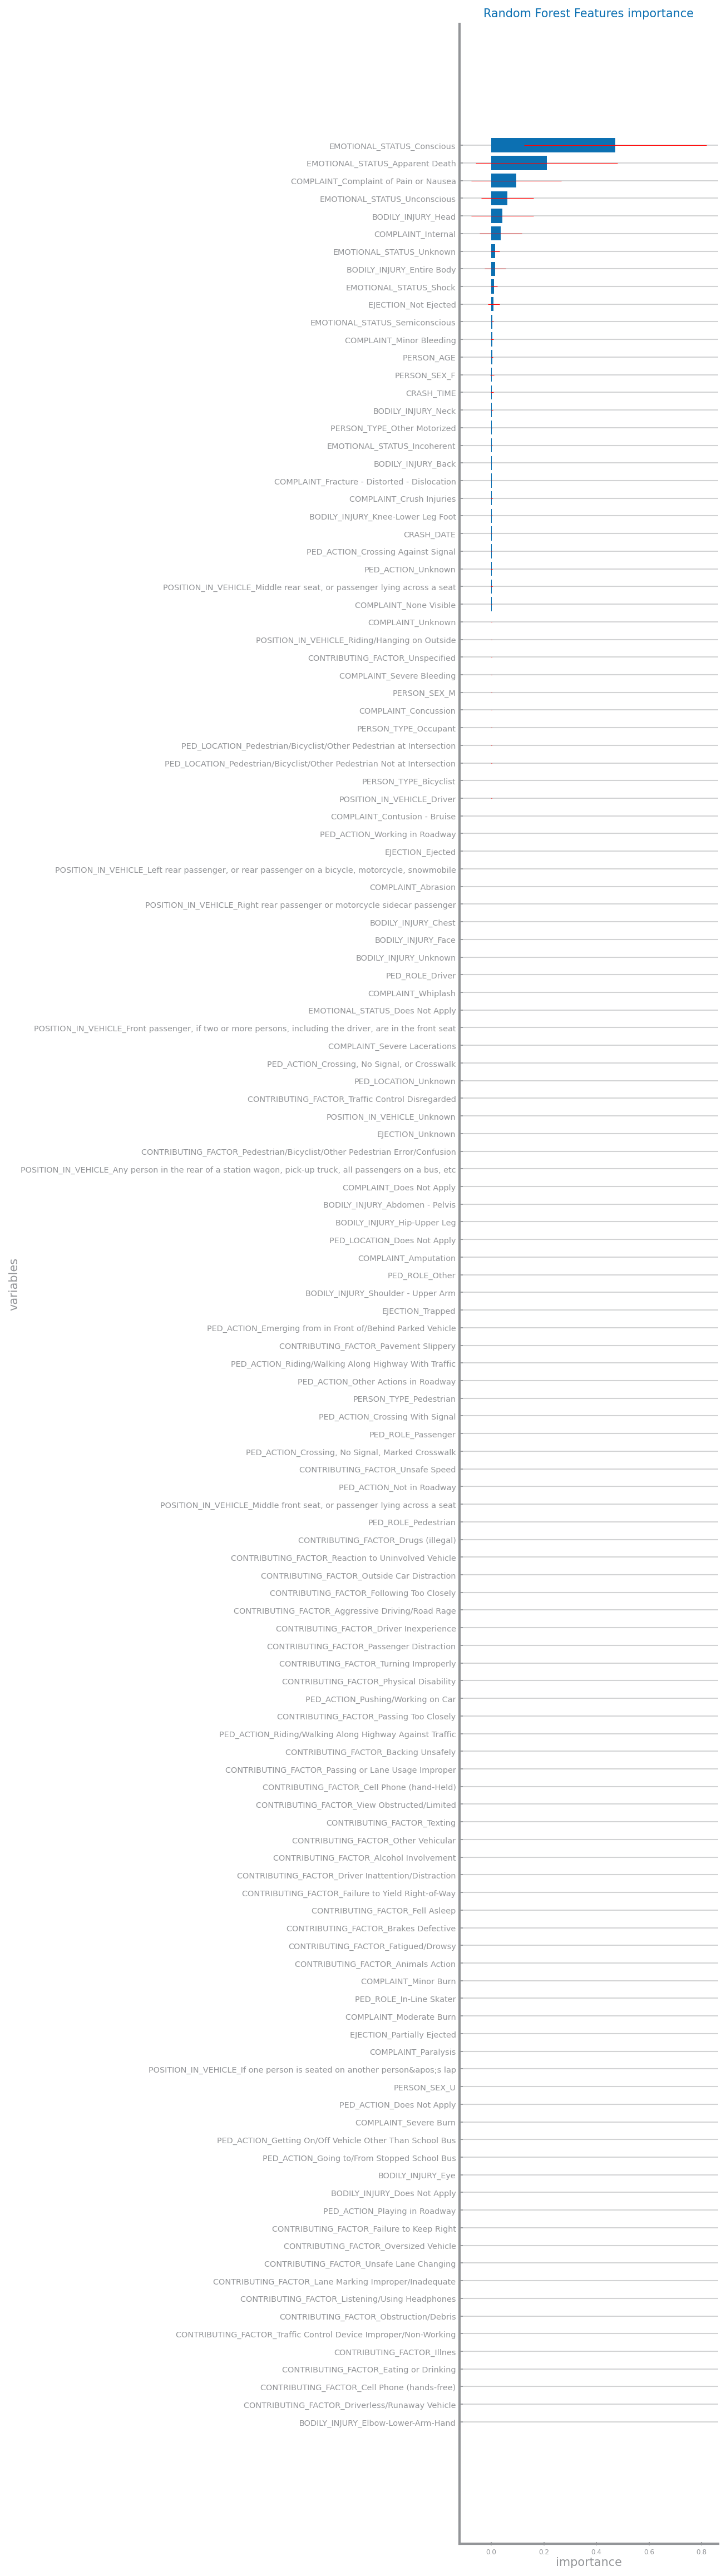

In [17]:
variables = train.columns
importances = best_model.feature_importances_
stdevs = std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
indices = argsort(importances)[::-1]
elems = []
for f in range(len(variables)):
    elems += [variables[indices[f]]]
    print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

figure()
fig, axs = subplots(1, 1, figsize=(HEIGHT, 10*HEIGHT), squeeze=False)
horizontal_bar_chart(elems, importances[indices], stdevs[indices], ax=axs[0, 0], title='Random Forest Features importance', xlabel='importance', ylabel='variables')
savefig(f'images/{file_tag}_scl_rf_ranking.png')

plot overfitting:

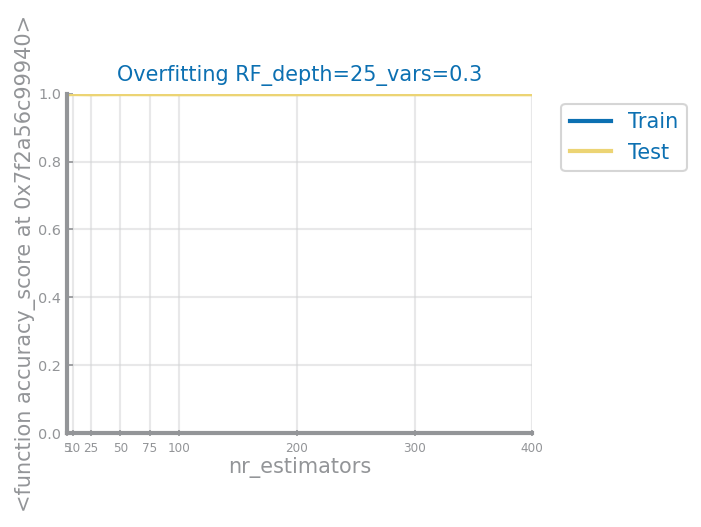

In [18]:
f = 0.3
max_depth = 25
eval_metric = metrics.accuracy_score
y_tst_values = []
y_trn_values = []
for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
    rf.fit(trnX, trnY)
    prd_tst_Y = rf.predict(tstX)
    prd_trn_Y = rf.predict(trnX)
    y_tst_values.append(eval_metric(tstY, prd_tst_Y))
    y_trn_values.append(eval_metric(trnY, prd_trn_Y))
plot_overfitting_study(n_estimators, y_trn_values, y_tst_values, name=f'RF_depth={max_depth}_vars={f}', xlabel='nr_estimators', ylabel=str(eval_metric))

## Dummified data without scaling:

load dataframes:

In [19]:
train: DataFrame = read_csv('data/train_sets/no_scaling.csv')
trnY: ndarray = train.pop(target).values
trnX: ndarray = train.values
labels = unique(trnY)
labels.sort()

test: DataFrame = read_csv('data/test_sets/no_scaling.csv')
tstY: ndarray = test.pop(target).values
tstX: ndarray = test.values

train models:

<Figure size 600x450 with 0 Axes>

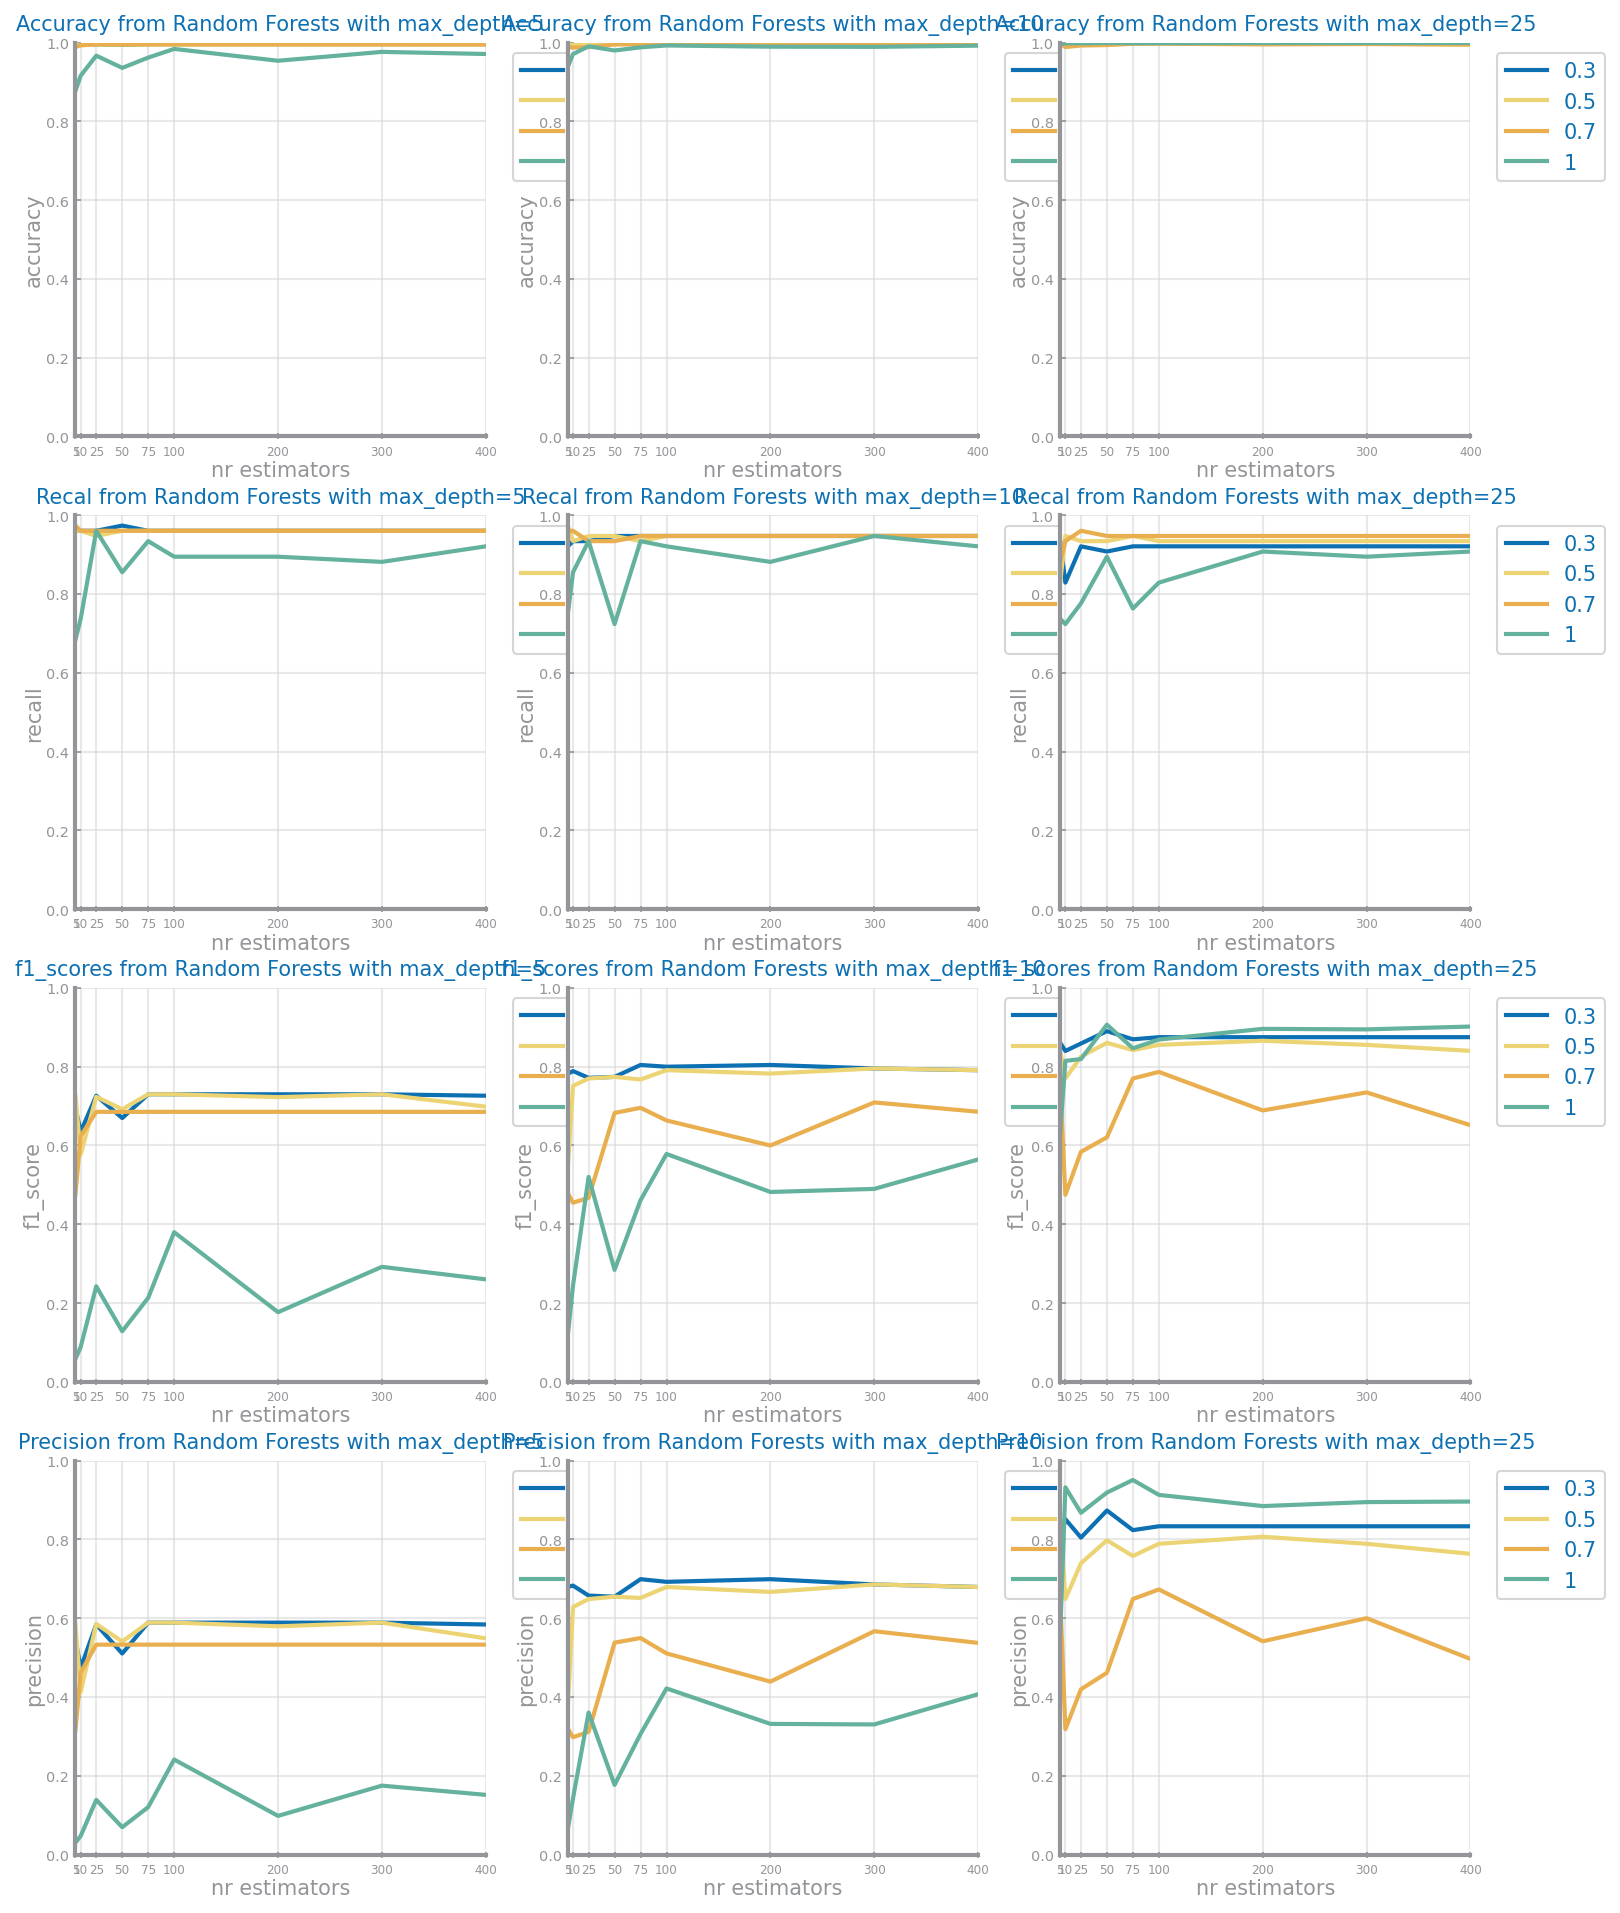

Best results with depth=25, 1.00 features and 50 estimators, with accuracy=1.00


In [20]:
n_estimators = [5, 10, 25, 50, 75, 100, 200, 300, 400]
max_depths = [5, 10, 25]
max_features = [.3, .5, .7, 1]
best = ('', 0, 0)
last_best = 0
best_model = None


cols = len(max_depths)
figure()
fig, axs = subplots(4, cols, figsize=(cols*HEIGHT, 4*HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]

    acc_values = {}
    recall_values = {}
    f1_values = {}
    precision_values = {}

    for f in max_features:
        recall = []
        f1_score = []
        accuracy = []
        precision = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)

            accuracy.append(metrics.accuracy_score(tstY, prdY))
            recall.append(metrics.recall_score(tstY, prdY, pos_label='Killed'))
            f1_score.append(metrics.f1_score(tstY, prdY, pos_label="Killed"))
            precision.append(metrics.precision_score(tstY, prdY, pos_label="Killed"))

            if accuracy[-1] > last_best:
                best = (d, f, n)
                last_best = accuracy[-1]
                best_model = rf
                
        precision_values[f] = precision
        acc_values[f] = accuracy
        recall_values[f] = recall
        f1_values[f] = f1_score

    multiple_line_chart(n_estimators, acc_values, ax=axs[0, k], title=f'Accuracy from Random Forests with max_depth={d}',
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
    multiple_line_chart(n_estimators, recall_values, ax=axs[1, k], title=f'Recal from Random Forests with max_depth={d}',
                           xlabel='nr estimators', ylabel='recall', percentage=True)
    multiple_line_chart(n_estimators, f1_values, ax=axs[2, k], title=f'f1_scores from Random Forests with max_depth={d}',
                           xlabel='nr estimators', ylabel='f1_score', percentage=True)
    multiple_line_chart(n_estimators, precision_values, ax=axs[3, k], title=f'Precision from Random Forests with max_depth={d}',
                           xlabel='nr estimators', ylabel='precision', percentage=True)

savefig(f'images/{file_tag}_rf_study.png')
show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

after analysis, define the best model:

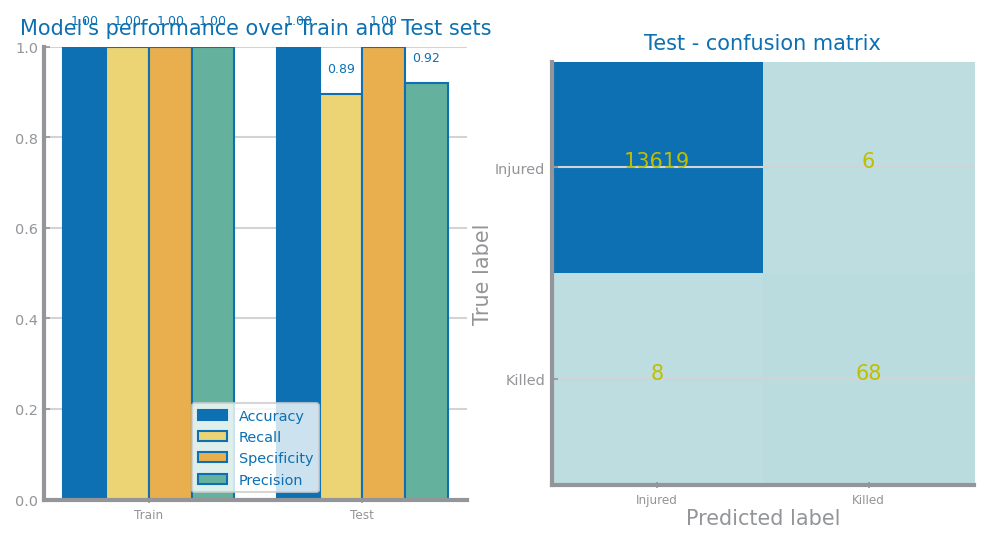

In [22]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
savefig(f'images/{file_tag}_rf_best.png')
show()

feature importance:

1. feature EMOTIONAL_STATUS_Conscious (0.16492658222504963)
2. feature EMOTIONAL_STATUS_Apparent Death (0.08252417067765404)
3. feature COMPLAINT_Internal (0.07673444301532362)
4. feature COMPLAINT_Complaint of Pain or Nausea (0.07249081922172101)
5. feature EJECTION_Not Ejected (0.058396112707646324)
6. feature EMOTIONAL_STATUS_Unconscious (0.05049449307923129)
7. feature BODILY_INJURY_Head (0.03451115696207429)
8. feature COMPLAINT_Crush Injuries (0.03407081178562433)
9. feature EJECTION_Ejected (0.03084231528007232)
10. feature BODILY_INJURY_Entire Body (0.0244682247783308)
11. feature BODILY_INJURY_Knee-Lower Leg Foot (0.02029737409268292)
12. feature COMPLAINT_None Visible (0.017528156361423946)
13. feature CRASH_TIME (0.015207250641254335)
14. feature PERSON_SEX_F (0.01305267973271928)
15. feature PERSON_TYPE_Occupant (0.012703557347668475)
16. feature PERSON_AGE (0.012521270049769771)
17. feature PERSON_SEX_M (0.012216529507813626)
18. feature CONTRIBUTING_FACTOR_Pedestrian/Bicy

<Figure size 600x450 with 0 Axes>

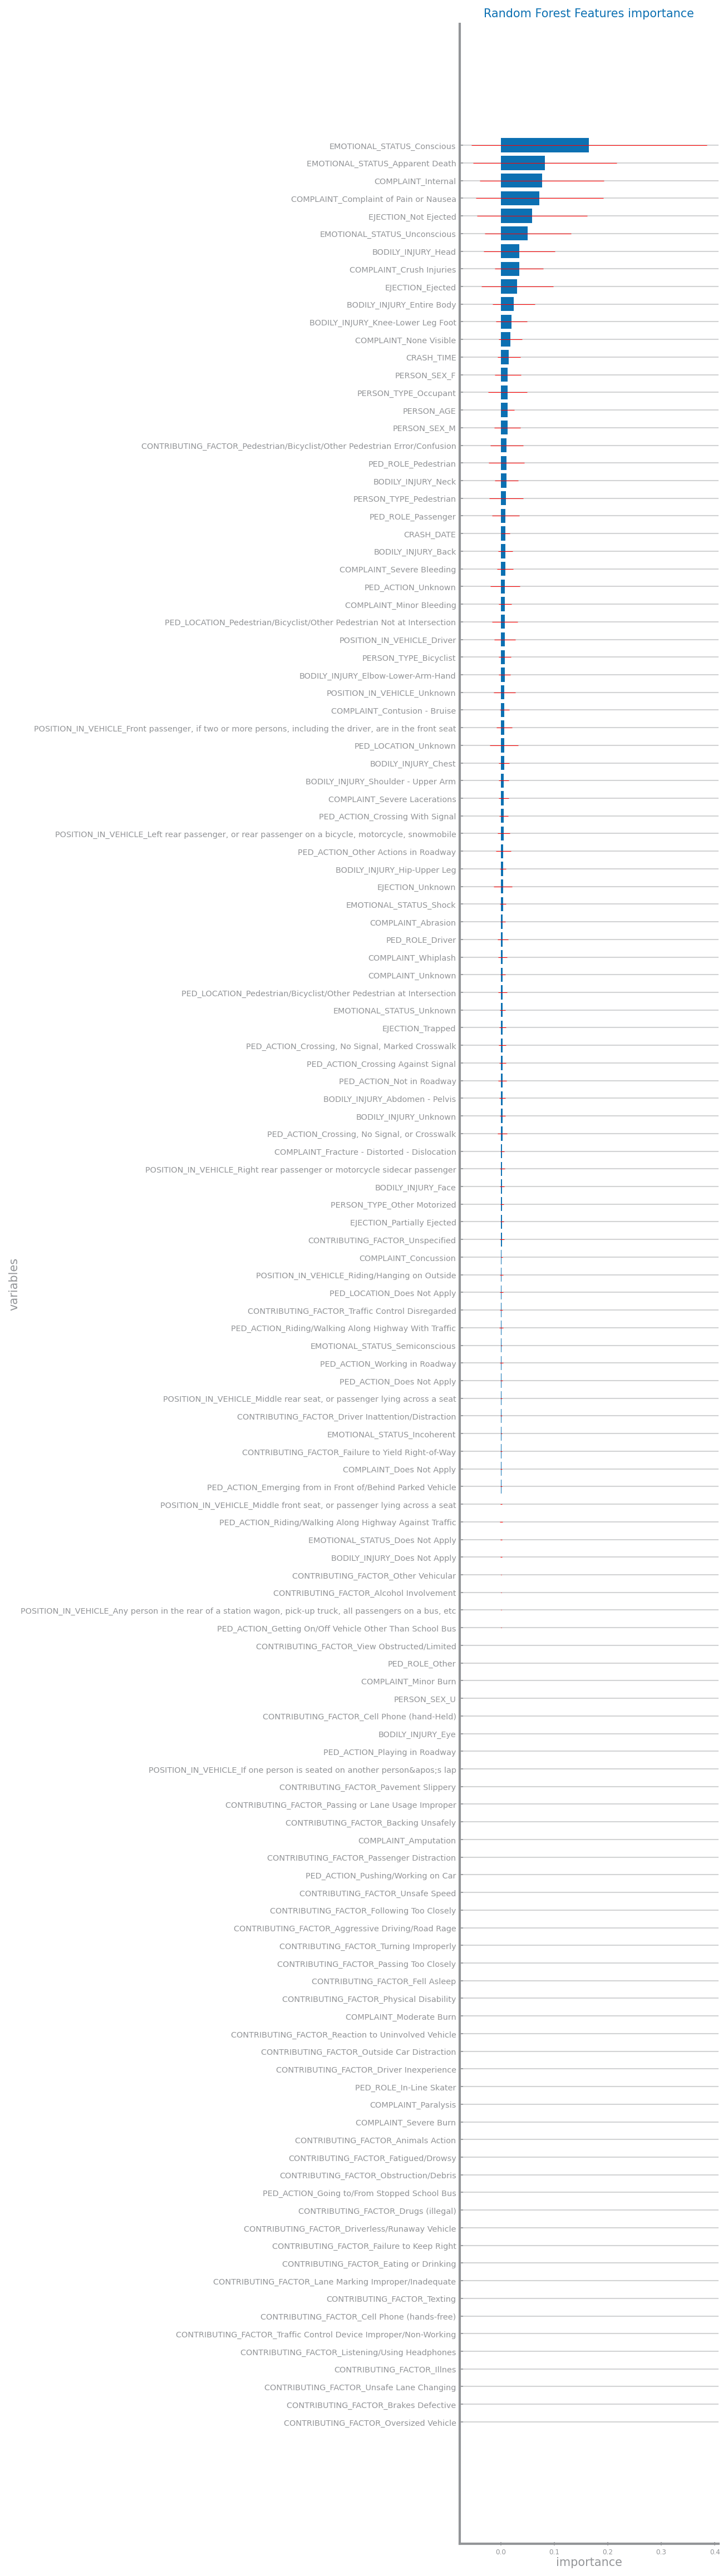

In [24]:
variables = train.columns
importances = best_model.feature_importances_
stdevs = std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
indices = argsort(importances)[::-1]
elems = []
for f in range(len(variables)):
    elems += [variables[indices[f]]]
    print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

figure()
fig, axs = subplots(1, 1, figsize=(HEIGHT, 10*HEIGHT), squeeze=False)
horizontal_bar_chart(elems, importances[indices], stdevs[indices], ax=axs[0, 0], title='Random Forest Features importance', xlabel='importance', ylabel='variables')
savefig(f'images/{file_tag}_rf_ranking.png')

plot overfitting:

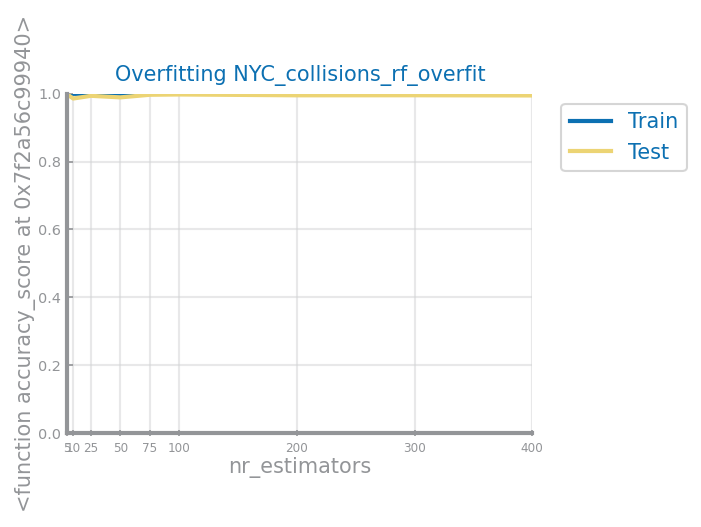

In [25]:
f = 0.7
max_depth = 10
eval_metric = metrics.accuracy_score
y_tst_values = []
y_trn_values = []
for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
    rf.fit(trnX, trnY)
    prd_tst_Y = rf.predict(tstX)
    prd_trn_Y = rf.predict(trnX)
    y_tst_values.append(eval_metric(tstY, prd_tst_Y))
    y_trn_values.append(eval_metric(trnY, prd_trn_Y))
plot_overfitting_study(n_estimators, y_trn_values, y_tst_values, name='NYC_collisions_rf_overfit', xlabel='nr_estimators', ylabel=str(eval_metric))